In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("../kc_house_data.csv")
data = data.fillna(data.mean())
data.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890.0,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715.0,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060.0,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050.0,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890.0,0,2003,0,98038,47.3684,-122.031,2390,7570


# Division de la variable price en classse

In [3]:
# On détermine le nombre de classe avec les méthodes suivante:

# Brooks-Carruthers
classe1 = 5 * math.log10(data.shape[0])

# Huntsberger
classe2 = 1 + 3.332 * math.log10(data.shape[0])

# Sturges
classe3 = math.log2(data.shape[0] + 1)

# Scott
classe4 = (data['price'].max() - data['price'].min())/(3.5 * data['price'].std() * data.shape[0]**(-1/3))

# Freedman-Diaconis 
classe5 = (data['price'].max() - data['price'].min())/(2 * (data['price'].quantile(0.75) - data['price'].quantile(0.25)) * data.shape[0]**(-1/3)) 

print(classe1)
print(classe2)
print(classe3)
print(classe4)
print(classe5)

21.67357526732179
15.443270558143242
14.399678469152942
165.29520811364517
328.73437891000515


In [4]:
# l'onjectif est d'avoir 15 classes
nbre_classe = 15

In [5]:
# Calcul de l'étendue
E = (data['price'].max() - data['price'].min())
E

7625000.0

In [6]:
# Calcul de la largeur des classes
largeur = E / nbre_classe
largeur

508333.3333333333

In [7]:
# considère donc que l'étendue est de 500.000
largeur = 500000

In [8]:
def discretisation(dat):
    for i in range(len(dat)):
        if dat[i] < 500000:
            dat[i] = '[0, 500 000['
        elif dat[i] < 1000000:
            dat[i] = '[500 000, 1 000 000['
        elif dat[i] < 1500000:
            dat[i] = '[1 000 000, 1 500 000['
        elif dat[i] < 2000000:
            dat[i] = '[1 500 000, 2 000 000['
        elif dat[i] < 2500000:
            dat[i] = '[2 000 000, 2 500 000['
        elif dat[i] < 3000000:
            dat[i] = '[2 500 000, 3 000 000['
        elif dat[i] < 3500000:
            dat[i] = '[3 000 000, 3 500 000['
        elif dat[i] < 4000000:
            dat[i] = '[3 500 000, 4 000 000['
        elif dat[i] < 4500000:
            dat[i] = '[4 000 000, 4 500 000['
        elif dat[i] < 5000000:
            dat[i] = '[4 500 000, 5 000 000['
        elif dat[i] < 5500000:
            dat[i] = '[5 000 000, 5 500 000['
        elif dat[i] < 6000000:
            dat[i] = '[5 500 000, 6 000 000['
        elif dat[i] < 6500000:
            dat[i] = '[6 000 000, 6 500 000['
        elif dat[i] < 7000000:
            dat[i] = '[6 500 000, 7 000 000['
        elif dat[i] < 7500000:
            dat[i] = '[7 000 000, 7 500 000['
        elif dat[i] < 8000000:
            dat[i] = '[7 500 000, 8 000 000['
    
    return dat

In [9]:
data_disc = pd.read_csv("../kc_house_data.csv")
data_disc = data_disc.fillna(data_disc.mean())

In [10]:
data_disc['price'] = discretisation(data_disc['price'])

/home/franel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/franel/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/franel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [11]:
data_disc.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,"[0, 500 000[",3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,"[500 000, 1 000 000[",3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,"[0, 500 000[",2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,"[500 000, 1 000 000[",4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,"[500 000, 1 000 000[",3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,"[1 000 000, 1 500 000[",4,4.50,5420,101930,1.0,0,0,...,11,3890.0,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,"[0, 500 000[",3,2.25,1715,6819,2.0,0,0,...,7,1715.0,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,"[0, 500 000[",3,1.50,1060,9711,1.0,0,0,...,7,1060.0,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,"[0, 500 000[",3,1.00,1780,7470,1.0,0,0,...,7,1050.0,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,"[0, 500 000[",3,2.50,1890,6560,2.0,0,0,...,7,1890.0,0,2003,0,98038,47.3684,-122.031,2390,7570


In [12]:
#labelBinarizer = preprocessing.LabelBinarizer(sparse_output=True)
y_voir = data_disc['price']
labelBinarizer = preprocessing.LabelBinarizer()
y_voir = labelBinarizer.fit_transform(y_voir)

y_voir

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

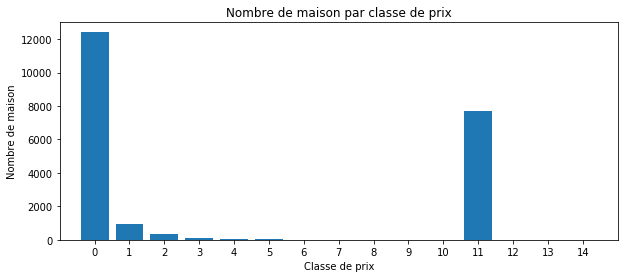

In [13]:
y_voir = data_disc['price']
labelBinarizer = preprocessing.LabelEncoder()
y_voir = labelBinarizer.fit_transform(y_voir)

price = defaultdict(int)
for nbre in y_voir:
    price[nbre] += 1
price = sorted(price.items(), key=lambda x: x[0])


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))

axes.bar([x for (x,y) in price], [y for (x,y) in price])
axes.set_xticks([x for (x,y) in price])
axes.axis([-1, 15, 0, 13000])
axes.set_ylabel("Nombre de maison")
axes.set_xlabel("Classe de prix")
axes.set_title("Nombre de maison par classe de prix")
fig.savefig('discrimination.png', transparent = True)
#fig.show()
#axes.close()

In [14]:
print(data.shape)
print(data_disc.shape)

(21613, 21)
(21613, 21)


In [15]:
X = data.drop(['id', 'date', 'price', 'zipcode'], axis=1)
y = np.array(data['price']).reshape(-1, 1)

X_cl = data_disc.drop(['id', 'date', 'price', 'zipcode'], axis=1)
y_cl = np.array(data_disc['price']).reshape(-1, 1)

labelEncoder = preprocessing.LabelEncoder()
y_cl = labelEncoder.fit_transform(y_cl).reshape(-1, 1)
y_cl.shape

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(21613, 1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=0)

# SVM

In [12]:
num_vars = make_column_selector(dtype_include=np.number)
cat_vars = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())
    
preprocessor = make_column_transformer((numerical_pipeline, num_vars),
                                      (categorical_pipeline, cat_vars))

model_svm= make_pipeline(preprocessor, SVC())

params = {'svc__decision_function_shape': ['ovo', 'ovr'],
         'svc__gamma': ['auto', 'scale'],
         'svc__kernel': ['rbf', 'poly']}

grid = GridSearchCV(model_svm, params, cv=5)

model_svm

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector objec...
                                                    

In [13]:
grid.fit(X_cl_train, y_cl_train)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [14]:
grid.best_params_

{'svc__decision_function_shape': 'ovo',
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf'}

In [15]:
grid.best_score_

0.8299016772700984

In [16]:
grid.score(X_cl_test, y_cl_test)

0.8489474901688642

In [17]:
model_svm = grid.best_estimator_

In [18]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=0)

In [391]:
val1 = []
val2 = []
for i in range(10, 60, 5):
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=i/100, random_state=0)
    val1.append('{}%'.format(i))
    model_svm.fit(X_cl_train, y_cl_train)
    val2.append(model_svm.score(X_cl_test, y_cl_test))

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

In [19]:
plt.plot(val1, val2)
plt.title("Recherche du meilleur découpage des données")
plt.xlabel("Pourcentage des données de test")
plt.ylabel("précision du modèle")

NameError: name 'val1' is not defined

In [20]:
model_svm.fit(X_cl_train, y_cl_train)
model_svm.score(X_cl_test, y_cl_test)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8489474901688642

In [22]:
model_svm.summary()

AttributeError: 'Pipeline' object has no attribute 'summary'

In [430]:
confusion = confusion_matrix(y_cl_test, model_svm.predict(X_cl_test))
confusion

array([[2350,    1,    0,    0,    0,    0,    0,    0,    0,  198],
       [   0,   74,   10,    0,    0,    0,    0,    0,    0,  112],
       [   0,   23,   14,    0,    0,    0,    0,    0,    0,   18],
       [   0,   13,   10,    0,    0,    0,    0,    0,    0,    1],
       [   0,    1,    3,    1,    0,    0,    0,    0,    0,    1],
       [   0,    2,    2,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    1,    0,    0,    0,    0,    0,    0,    0],
       [   0,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    1],
       [ 233,   19,    2,    0,    0,    0,    0,    0,    0, 1232]])

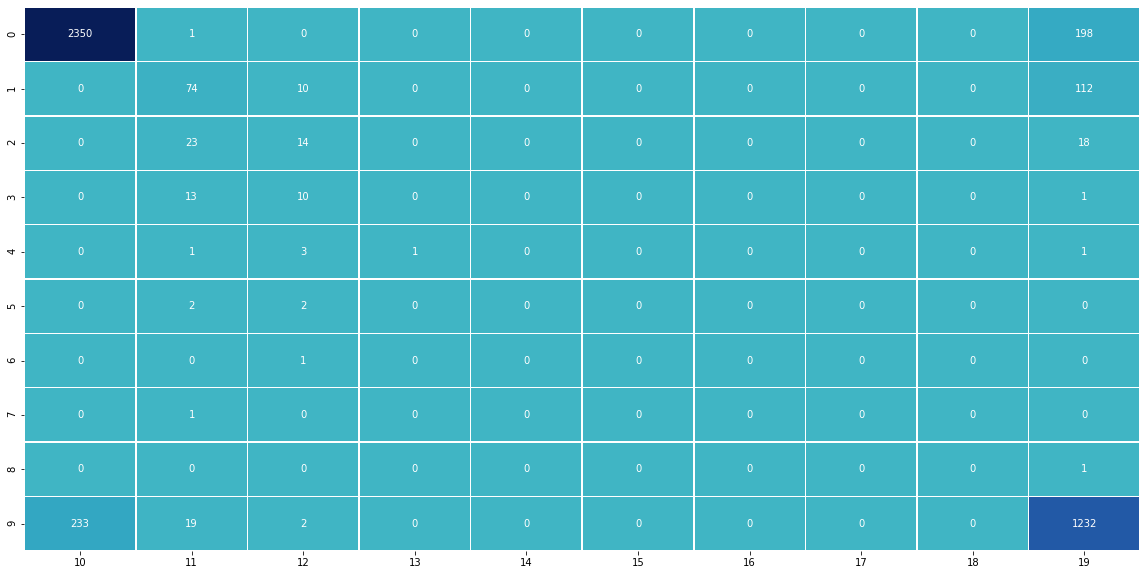

In [431]:
plt.figure(figsize=(20,10))
sns.heatmap(confusion, center=0, annot=True, fmt="d", linewidths=.5, cbar=False, cmap="YlGnBu", xticklabels=range(10,20))

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for examp

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

[ 2766  3995  5225  6454  7684  8913 10143 11372 12602 13832]


TypeError: yscale() takes 1 positional argument but 2 were given

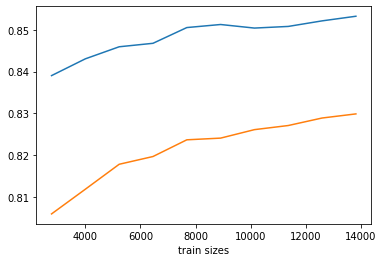

In [432]:
N, train_score_svm, val_score_svm = learning_curve(model_svm, X_cl_train, y_cl_train, train_sizes=np.linspace(0.2, 1, 10), cv=5)



[ 2766  3995  5225  6454  7684  8913 10143 11372 12602 13832]


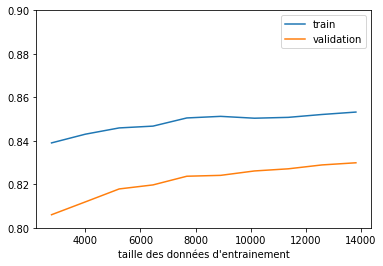

In [437]:
print(N)

plt.plot(N, train_score_svm.mean(axis=1), label='train')
plt.plot(N, val_score_svm.mean(axis=1), label='validation')
plt.xlabel('taille des données d\'entrainement')
plt.ylim(0.8, 0.9)
plt.legend()

# KNN

In [448]:
num_vars = make_column_selector(dtype_include=np.number)
cat_vars = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())
    
preprocessor = make_column_transformer((numerical_pipeline, num_vars),
                                      (categorical_pipeline, cat_vars))


model_knn= make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=3))

params = {'kneighborsclassifier__n_neighbors': range(2,10)}

grid_knn = GridSearchCV(model_knn, params, cv=5)

model_knn

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector objec...
                                                    

In [449]:
grid_knn.fit(X_cl_train, y_cl_train)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), f

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [450]:
grid_knn.best_params_

{'kneighborsclassifier__n_neighbors': 7}

In [451]:
grid_knn.best_score_

0.814921920185078

In [452]:
grid_knn.score(X_cl_test, y_cl_test)

0.8350682396483923

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), f

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, whi

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), f

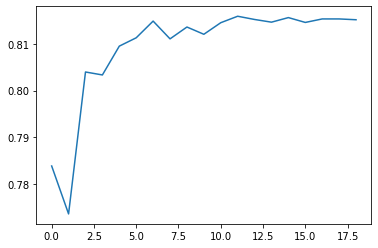

In [457]:
best_score = []
for k in range(1, 20):
    model_knn= make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=k))
    score = cross_val_score(model_knn, X_cl_train, y_cl_train, cv=5).mean()
    best_score.append(score)
    
plt.plot(best_score)

In [458]:
model_knn = grid_knn.best_estimator_

In [459]:
val1 = []
val2 = []
for i in range(10, 60, 5):
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=i/100, random_state=0)
    val1.append('{}%'.format(i))
    model_knn.fit(X_cl_train, y_cl_train)
    val2.append(model_knn.score(X_cl_test, y_cl_test))

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Text(0, 0.5, 'précision du modèle')

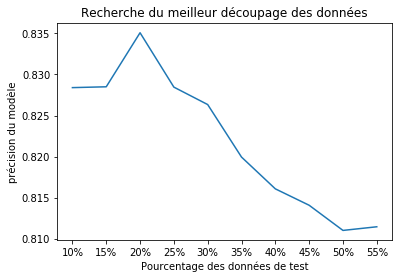

In [460]:
plt.plot(val1, val2)
plt.title("Recherche du meilleur découpage des données")
plt.xlabel("Pourcentage des données de test")
plt.ylabel("précision du modèle")

In [461]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=0)
N, train_score_knn, val_score_knn = learning_curve(model_knn, X_cl_train, y_cl_train, train_sizes=np.linspace(0.2, 1, 10), cv=5)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), f

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

[ 2766  3995  5225  6454  7684  8913 10143 11372 12602 13832]


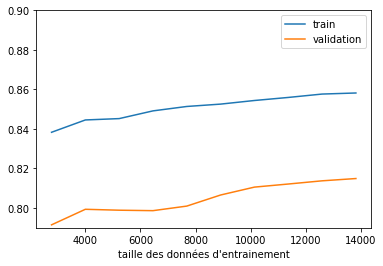

In [465]:
print(N)

plt.plot(N, train_score_knn.mean(axis=1), label='train')
plt.plot(N, val_score_knn.mean(axis=1), label='validation')
plt.xlabel('taille des données d\'entrainement')
plt.ylim(0.79, 0.9)
plt.legend()

In [446]:
model_knn.fit(X_cl_train, y_cl_train)
model_knn.score(X_cl_test, y_cl_test)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.8214203099699283

# Arbre de décision

In [482]:
num_vars = make_column_selector(dtype_include=np.number)
cat_vars = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())
    
preprocessor = make_column_transformer((numerical_pipeline, num_vars),
                                      (categorical_pipeline, cat_vars))

model_arbre= make_pipeline(preprocessor, DecisionTreeClassifier())

params = {'decisiontreeclassifier__criterion': ['gini', 'entropy']}

grid_arbre = GridSearchCV(model_arbre, params, cv=5)

model_arbre

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector objec...
                                   verbose=False)),


In [483]:
grid_arbre.fit(X_cl_train, y_cl_train)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [469]:
grid_arbre.best_params_

{'decisiontreeclassifier__criterion': 'gini'}

In [470]:
grid_arbre.best_score_

0.811683053788317

In [471]:
grid_arbre.score(X_cl_test, y_cl_test)

0.8228082350219755

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


<BarContainer object of 2 artists>

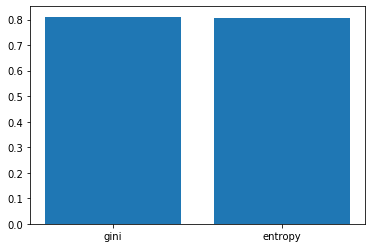

In [474]:
best_score = []
for k in ['gini', 'entropy']:
    model_arbre = make_pipeline(preprocessor, DecisionTreeClassifier(criterion=k))
    score = cross_val_score(model_arbre, X_cl_train, y_cl_train, cv=5).mean()
    best_score.append(score)
    
plt.bar(['gini', 'entropy'], best_score)

In [485]:
val1 = []
val2 = []
for i in range(10, 60, 5):
    X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=i/100, random_state=0)
    val1.append('{}%'.format(i))
    model_arbre.fit(X_cl_train, y_cl_train)
    val2.append(model_arbre.score(X_cl_test, y_cl_test))

Text(0, 0.5, 'précision du modèle')

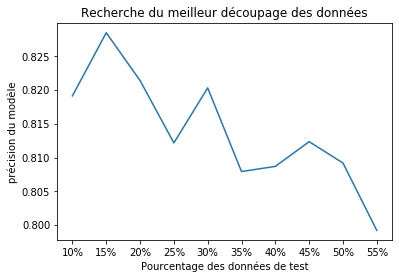

In [486]:
plt.plot(val1, val2)
plt.title("Recherche du meilleur découpage des données")
plt.xlabel("Pourcentage des données de test")
plt.ylabel("précision du modèle")

In [487]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.15, random_state=0)
model_arbre = grid_arbre.best_estimator_
model_arbre.fit(X_cl_train, y_cl_train)
model_arbre.score(X_cl_test, y_cl_test)

0.82449105490438

In [489]:
X_cl_train, X_cl_test, y_cl_train, y_cl_test = train_test_split(X_cl, y_cl, test_size=0.2, random_state=0)
N, train_score_arbre, val_score_arbre = learning_curve(model_arbre, X_cl_train, y_cl_train, train_sizes=np.linspace(0.2, 1, 10), cv=5)

/home/franel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


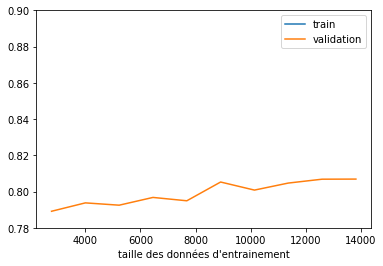

In [499]:
plt.plot(N, train_score_arbre.mean(axis=1), label='train')
plt.plot(N, val_score_arbre.mean(axis=1), label='validation')
plt.xlabel('taille des données d\'entrainement')
plt.ylim(0.78, 0.9)
plt.legend()

# Regréssion linéaire

In [41]:
num_vars = make_column_selector(dtype_include=np.number)
cat_vars = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())
    
preprocessor = make_column_transformer((numerical_pipeline, num_vars),
                                      (categorical_pipeline, cat_vars))

model_reg= make_pipeline(preprocessor, PolynomialFeatures(), LinearRegression())

params = {'polynomialfeatures__degree': [1]}

grid_reg = GridSearchCV(model_reg, params, cv=5)

model_reg

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector objec...
                                                    

In [42]:
grid_reg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [43]:
grid_reg.best_params_

{'polynomialfeatures__degree': 1}

In [44]:
grid_reg.best_score_

0.6924130210340339

In [45]:
grid_reg.score(X_test, y_test)

0.6889318410219809

In [22]:
model_reg = grid_reg.best_estimator_

In [23]:
val1 = []
val2 = []
for i in range(10, 60, 5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/100, random_state=0)
    val1.append('{}%'.format(i))
    model_reg.fit(X_train, y_train)
    val2.append(model_reg.score(X_test, y_test))

Text(0, 0.5, 'précision du modèle')

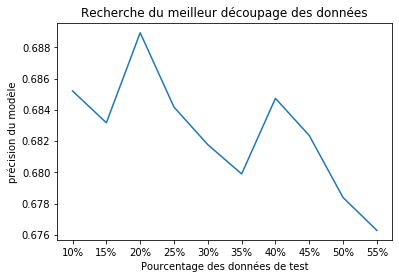

In [24]:
plt.plot(val1, val2)
plt.title("Recherche du meilleur découpage des données")
plt.xlabel("Pourcentage des données de test")
plt.ylabel("précision du modèle")

<BarContainer object of 3 artists>

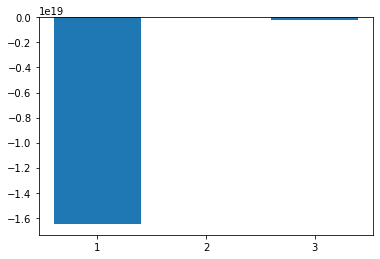

In [26]:
best_score = []
for k in [1, 2, 3]:
    model_r = make_pipeline(preprocessor, PolynomialFeatures(degree=k), LinearRegression())
    score = cross_val_score(model_r, X_train, y_train, cv=5).mean()
    best_score.append(score)
    
plt.bar(['1', '2', '3'], best_score)

In [30]:
best_score

[-1.6534740430558669e+19, -728245814289162.8, -1.8686188043833968e+17]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
N, train_score_reg, val_score_reg = learning_curve(model_reg, X_train, y_train, train_sizes=np.linspace(0.2, 1, 10), cv=5)

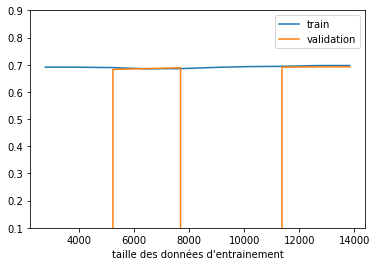

In [28]:
plt.plot(N, train_score_reg.mean(axis=1), label='train')
plt.plot(N, val_score_reg.mean(axis=1), label='validation')
plt.xlabel('taille des données d\'entrainement')
plt.ylim(0.1, 0.9)
plt.legend()

# SVR (Regréssion linéaire)

In [82]:
num_vars = make_column_selector(dtype_include=np.number)
cat_vars = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder())
    
preprocessor = make_column_transformer((numerical_pipeline, num_vars),
                                      (categorical_pipeline, cat_vars))

model_svr= make_pipeline(preprocessor, SVR())

params = {'svr__C': range(1000, 1001),
         'svr__kernel': ['rbf', 'linear', 'poly'],
         'svr__degree': range(1,5),
         'svr__gamma': ['auto', 'scale']}

grid_svr = GridSearchCV(model_svr, params, cv=5)

model_svr

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('standardscaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector objec...
                                                    

In [83]:
y_train = np.array(y_train).reshape(-1)
grid_svr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('standardscaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                    

In [84]:
grid_svr.best_params_

{'svr__degree': 1, 'svr__gamma': 'auto', 'svr__kernel': 'linear'}

In [85]:
grid_svr.best_score_

0.07392691448731228

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
model.score(X_test, y_test) #Notre modèle décrit 68% de la variation du prix des maisons à ...

0.688931841021968